 **VANILLA NEURAL NETWORK**

In [1]:
import os
print(os.getcwd())


C:\Users\shres\Downloads


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc as sk_auc, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset


data_path = 'medical_appointment_dataset.csv'  
df = pd.read_csv(data_path)

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())

Dataset shape: (110527, 14)

First few rows:
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0    

Data Preprocessing

In [6]:
data = df.copy()

data['ScheduledDay'] = pd.to_datetime(data['ScheduledDay'])
data['AppointmentDay'] =pd.to_datetime(data['AppointmentDay'])

#feature engineering
data['DaysAdvance']= (data['AppointmentDay'] - data['ScheduledDay']).dt.days
data['ScheduledDayOfWeek'] =data['ScheduledDay'].dt.dayofweek
data['AppointmentDayOfWeek']= data['AppointmentDay'].dt.dayofweek
data['ScheduledHour'] =data['ScheduledDay'].dt.hour

#categorical variables encoded by LabelEncoder
le_gender = LabelEncoder()
data['Gender_encoded'] = le_gender.fit_transform(data['Gender'])
le_neighbourhood = LabelEncoder()
data['Neighbourhood_encoded'] = le_neighbourhood.fit_transform(data['Neighbourhood'])


data['No-show'] = (data['No-show'] == 'Yes').astype(int)   #converting to integer

#One hot encoding for ScheduledDayOfWeek, AppointmentDayOfWeek, ScheduledHour
data = pd.get_dummies(data, columns=['ScheduledDayOfWeek','AppointmentDayOfWeek','ScheduledHour'], drop_first=False)

#excluding original day/hour columns becoz one hot encoded
feature_columns = ['Gender_encoded','Age','Neighbourhood_encoded','Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received','DaysAdvance']

one_hot_columns=[]
for i in data.columns:
    if i.startswith('ScheduledDayOfWeek_') or i.startswith('AppointmentDayOfWeek_') or i.startswith('ScheduledHour_'):   #this part written with GPT
        one_hot_columns.append(i)


feature_columns.extend(one_hot_columns)

X = data[feature_columns].values
y = data['No-show'].values

#standardizing numerical features (Age and DaysAdvance)
features_to_scale = ['Age', 'DaysAdvance']
scaler = StandardScaler()
scale_indices = [feature_columns.index(f) for f in features_to_scale]

# Scale only those columns
X[:, scale_indices] = scaler.fit_transform(X[:, scale_indices])



=============================================================================================================== <br>**Numpy from scratch** <br>
=============================================================================================================== <br>


Data splitting

In [23]:
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set shape:",X_train.shape)
print("Cross-validation set shape:", X_cv.shape)
print("Training labels distribution:")
print(pd.Series(y_train).value_counts())
print("Cross-validation labels distribution:")
print(pd.Series(y_cv).value_counts())

Training set shape: (88421, 38)
Cross-validation set shape: (22106, 38)
Training labels distribution:
0.0    70566
1.0    17855
Name: count, dtype: int64
Cross-validation labels distribution:
0.0    17642
1.0     4464
Name: count, dtype: int64


In [26]:
def sigmoid(X):
    X = np.array(X, dtype=np.float64)
    cache = [X]
    return 1/(1+np.exp(-X)), cache

def relu(Z):
    cache=[]
    A=np.maximum(0,Z)
    cache.append(Z)
    return A,cache

In [30]:
def initialize_parameters(layers_dims):  #38,8,1
    parameters={}
    np.random.seed(1)
    for l in range(1,len(layers_dims)):
        parameters['W'+str(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])*0.01
        parameters['b'+str(l)]=np.zeros((layers_dims[l],1))
    
    return parameters

In [32]:
def linear_forward(A, W, b):  
    Z = np.dot(W,A) + b
    
    cache = (A, W, b)
    return Z,cache

In [34]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache =linear_forward(A_prev, W, b)
        A,activation_cache = sigmoid(Z)      #activation cache is Z and linear cache is (A,W,b)
    
    elif activation=="relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A,activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

In [36]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters)//2                  #no. of layers in the nn
    
    for l in range(1,L):
        A_prev=A
        A,cache =linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"sigmoid")   #AL is last activation
    caches.append(cache)
    
    return AL, caches

In [38]:
def compute_cost(AL, Y, parameters, pos_weight, lambd):
    m = Y.shape[1]
    weighted_Y = pos_weight * Y
    cost_ = -(1/m)*(np.dot(weighted_Y,np.log(AL).T) + np.dot((1-Y),np.log(1-AL).T))
    
    L2_cost = 0
    if lambd!= 0:
        L = len(parameters)//2
        for l in range(1, L+1):
            L2_cost += np.sum(np.square(parameters["W" + str(l)]))
        L2_cost = (lambd/(2*m))*L2_cost

    cost = np.squeeze(cost_ + L2_cost)
    return cost

In [40]:
def linear_backward(dZ, cache, lambd=0.0):     #cache is linear cache 
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1/m)*np.dot(dZ, A_prev.T)+ (lambd/m)*W
    db = (1/m)*np.sum(dZ, axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)

    return dA_prev, dW, db


In [42]:
def sigmoid_backward(dA,cache):
    Z=cache[0]   #cache[0]= A_prev
    S = 1/(1+np.exp(-Z))
    dZ= dA * S * (1-S)
    return dZ

In [44]:
def relu_backward(dA,cache):
    Z = cache[0]
    dZ = np.array(dA, copy=True)
    dZ[Z<=0]=0
    return dZ

In [46]:
def linear_activation_backward(dA, cache, activation, lambd=0.0):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ =relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ =sigmoid_backward(dA, activation_cache)
    
    dA_prev,dW,db=linear_backward(dZ,linear_cache,lambd)

    return dA_prev, dW, db



In [48]:
def L_model_backward(AL, Y, caches, lambd=0.0):
    grads = {}
    L = len(caches)         #no. of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)          #after this line, Y is the same shape as AL
    
    dAL = -(np.divide(Y,AL)-np.divide(1-Y, 1-AL))
    
    current_cache=caches[L-1]          
    grads["dA" + str(L-1)], grads["dW" +str(L)], grads["db"+str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid",lambd=lambd)

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation = "relu", lambd=lambd)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [50]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)//2         #no. of layers in the nn

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" +str(l+1)]-learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" +str(l+1)]-learning_rate*grads["db" + str(l+1)]
        
    return parameters

In [52]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    np.random.seed(seed)

    if Y.ndim == 1:
        Y = Y.reshape(1, -1)  #Converting to 2D(1, m) becoz of an unexpeccted error occured later
    m = X.shape[1]
    mini_batches = []
    
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    num_complete_batches = m // mini_batch_size
    for k in range(num_complete_batches):
        batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batches.append((batch_X, batch_Y))
    
    if m % mini_batch_size != 0:
        batch_X = shuffled_X[:, num_complete_batches*mini_batch_size:]
        batch_Y = shuffled_Y[:, num_complete_batches*mini_batch_size:]
        mini_batches.append((batch_X, batch_Y))
    
    return mini_batches


In [54]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.01, num_iterations=1000, mini_batch_size=64, print_cost=True, lambd=0.0):
    np.random.seed(1)
    costs=[]
    parameters = initialize_parameters(layers_dims)
    
    for i in range(num_iterations):
        minibatches = random_mini_batches(X,Y,mini_batch_size)
        
        for batch in minibatches:
            batch_X, batch_Y = batch
            
            AL, caches = L_model_forward(batch_X, parameters)     #forward prop
            cost = compute_cost(AL, batch_Y, parameters, pos_weight, lambd)    #cost
            grads = L_model_backward(AL, batch_Y, caches, lambd)    #back prop
            parameters = update_parameters(parameters, grads, learning_rate)      #parameter updates
        
        if print_cost and i % 100 == 0:
            print(f"Cost after iteration {i}: {cost}")
        costs.append(cost)
    
    return parameters,costs


In [56]:
#model architecture
n_x = X_train.shape[1]
n_h = 8
n_y = 1
layers_dims=[n_x,n_h,n_y]

In [58]:
#cost sensitive learning
neg = np.sum(y_train== 0)
pos = np.sum(y_train == 1)
pos_weight = neg/pos

Cost after iteration 0: 1.690657173808153
Cost after iteration 100: 1.5009036499970598
Cost after iteration 200: 1.5019962761175023
Cost after iteration 300: 1.4811800854223791
Cost after iteration 400: 1.4916243364719288
Cost after iteration 500: 1.5122467594020421
Cost after iteration 600: 1.49933535456391
Cost after iteration 700: 1.5121160176557367
Cost after iteration 800: 1.5163102191433517
Cost after iteration 900: 1.5230062542324228
Cost after iteration 1000: 1.5270925680555387
Cost after iteration 1100: 1.5331175955806475
Cost after iteration 1200: 1.5219287244004494
Cost after iteration 1300: 1.508362249285285
Cost after iteration 1400: 1.5067913742985213
Cost after iteration 1500: 1.5046145461573626
Cost after iteration 1600: 1.5074625654277096
Cost after iteration 1700: 1.499903795566354
Cost after iteration 1800: 1.4825306504211213
Cost after iteration 1900: 1.4830696721629635
Cost after iteration 2000: 1.4654593131193032
Cost after iteration 2100: 1.4664419312206152
Cost 

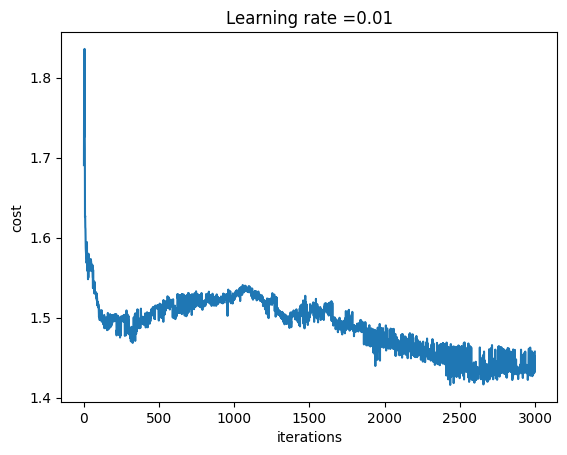

In [60]:
import time
import psutil
import os

process = psutil.Process(os.getpid())

# Measure memory before
mem_before = process.memory_info().rss / (1024 ** 2)  # in MB

# Measure time before
start_time = time.time()

# Reshape y_train to 2D before passing to model
parameters,costs = two_layer_model(X_train.T, y_train.reshape(1, -1),layers_dims, learning_rate=0.01, num_iterations=3000, mini_batch_size=64, print_cost=True, lambd=0.01)

# Measure memory after
mem_after = process.memory_info().rss / (1024 ** 2)  # in MB

# Measure time after
end_time=time.time()
total_time = end_time - start_time


print(f"\nTraining time: {total_time:.2f} seconds")
print(f"Memory usage: {mem_after - mem_before:.2f} MB")

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =0.01")
plt.show()



In [61]:
def predict(x, y, parameters, threshold=0.5):
    m = x.shape[1]
    p = np.zeros((1, m))
    AL, caches = L_model_forward(x, parameters)
    for i in range(AL.shape[1]):
        if AL[0,i]>threshold:
            p[0,i]=1
        else:
            p[0,i]=0

    accuracy = np.sum(p == y) / m
    print(f"Accuracy: {accuracy:.6f}")
    return p


In [64]:
#tuning decision threshold
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for t in thresholds:
    preds = predict(X_cv.T, y_cv.T, parameters, threshold=t)
    f1 = f1_score(y_cv.T.flatten(), preds.flatten())
    f1_scores.append(f1)
    print(f"Threshold: {t:.2f}, F1 Score: {f1:.4f}")


Accuracy: 0.554148
Threshold: 0.10, F1 Score: 0.4378
Accuracy: 0.583552
Threshold: 0.15, F1 Score: 0.4379
Accuracy: 0.624672
Threshold: 0.20, F1 Score: 0.4402
Accuracy: 0.680223
Threshold: 0.25, F1 Score: 0.4321
Accuracy: 0.728942
Threshold: 0.30, F1 Score: 0.3952
Accuracy: 0.772550
Threshold: 0.35, F1 Score: 0.2896
Accuracy: 0.793314
Threshold: 0.40, F1 Score: 0.1282
Accuracy: 0.796300
Threshold: 0.45, F1 Score: 0.0530
Accuracy: 0.797476
Threshold: 0.50, F1 Score: 0.0184
Accuracy: 0.797792
Threshold: 0.55, F1 Score: 0.0036
Accuracy: 0.798019
Threshold: 0.60, F1 Score: 0.0004
Accuracy: 0.798064
Threshold: 0.65, F1 Score: 0.0000
Accuracy: 0.798064
Threshold: 0.70, F1 Score: 0.0000
Accuracy: 0.798064
Threshold: 0.75, F1 Score: 0.0000
Accuracy: 0.798064
Threshold: 0.80, F1 Score: 0.0000
Accuracy: 0.798064
Threshold: 0.85, F1 Score: 0.0000


In [66]:
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best Threshold: {best_threshold}, Best F1 Score: {f1_scores[best_idx]:.4f}")


Best Threshold: 0.20000000000000004, Best F1 Score: 0.4402


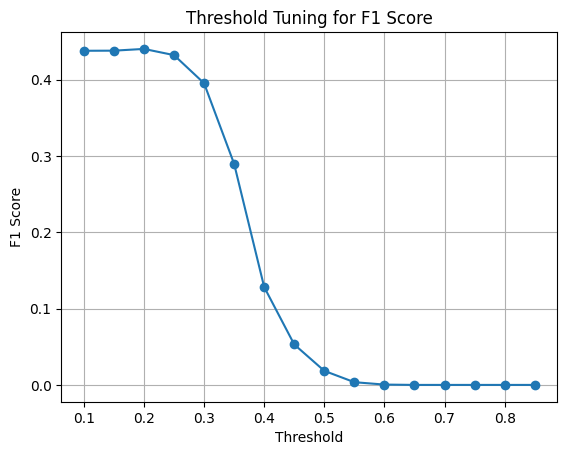

In [68]:
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold Tuning for F1 Score")
plt.grid(True)
plt.show()


In [70]:
predictions_train = predict(X_train.T,y_train.T,parameters, threshold= best_threshold)
predictions_test = predict(X_cv.T,y_cv.T,parameters, threshold= best_threshold)

Accuracy: 0.624818
Accuracy: 0.624672


=============================================================================================================== <br>**PyTorch Implementation** <br>
=============================================================================================================== <br>


In [8]:
import torch.nn as nn
import torch.optim as optim
import torch
import psutil
import time
import os

In [12]:
from sklearn.model_selection import train_test_split

X = X.astype(np.float32)
y = y.astype(np.float32)

X_train_np,X_cv_np,y_train_np,y_cv_np = train_test_split(X,y,test_size=0.2,stratify=y, random_state=42)

X_train_t = torch.from_numpy(X_train_np).float()
y_train_t =torch.from_numpy(y_train_np).float().unsqueeze(1)
X_cv_t = torch.from_numpy(X_cv_np).float()
y_cv_t = torch.from_numpy(y_cv_np).float().unsqueeze(1)

print("Training set shape:",X_train_t.shape, y_train_t.shape)
print("Crossvalidation set shape:", X_cv_t.shape, y_cv_t.shape)



Training set shape: torch.Size([88421, 38]) torch.Size([88421, 1])
Crossvalidation set shape: torch.Size([22106, 38]) torch.Size([22106, 1])


In [14]:
#for cost sensitive learning 
n_pos = (y_train_np == 1).sum()
n_neg = (y_train_np == 0).sum()

In [16]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



In [18]:
n_x = X_train_t.shape[1]
n_h = 8
n_y = 1

model = ANN(n_x,n_h,n_y)

# 1) Compute pos_weight based on your train labels (NumPy arrays)
n_pos = int((y_train_np == 1).sum())
n_neg = int((y_train_np == 0).sum())
if n_pos == 0:
    pos_weight_value = 1.0
else:
    pos_weight_value = n_neg/n_pos

# 2) Create a 1‐element tensor for pos_weight
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32)

# 3) Use BCEWithLogitsLoss with that pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

optimizer =optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-4 )

Epoch  100 — cost: 1.002631
Epoch  200 — cost: 0.972465
Epoch  300 — cost: 0.961153
Epoch  400 — cost: 0.958930
Epoch  500 — cost: 0.957556
Epoch  600 — cost: 0.955154
Epoch  700 — cost: 0.954189
Epoch  800 — cost: 0.956198
Epoch  900 — cost: 0.953420
Epoch 1000 — cost: 0.953962
Epoch 1100 — cost: 0.953411
Epoch 1200 — cost: 0.953457
Epoch 1300 — cost: 0.953512
Epoch 1400 — cost: 0.953370
Epoch 1500 — cost: 0.953567
Epoch 1600 — cost: 0.953307
Epoch 1700 — cost: 0.952944
Epoch 1800 — cost: 0.953344
Epoch 1900 — cost: 0.952439
Epoch 2000 — cost: 0.953202
Epoch 2100 — cost: 0.953543
Epoch 2200 — cost: 0.952603
Epoch 2300 — cost: 0.952972
Epoch 2400 — cost: 0.952040
Epoch 2500 — cost: 0.952428
Epoch 2600 — cost: 0.952077
Epoch 2700 — cost: 0.951944
Epoch 2800 — cost: 0.952288
Epoch 2900 — cost: 0.952163
Epoch 3000 — cost: 0.951784

Total training time: 23.01 seconds
CPU memory used: 13.67 MB


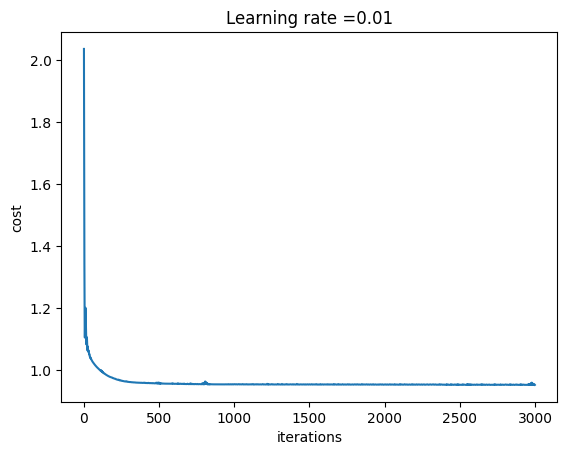

In [19]:
process = psutil.Process(os.getpid())
mem_before = process.memory_info().rss / (1024**2)

if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()


#training
eplist, losslist = [],[]
start_time = time.time()

for epoch in range(1, 3001):
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losslist.append(loss.item())
    eplist.append(epoch)

    if epoch%100==0 or epoch==1000 or epoch==0:
        print(f"Epoch {epoch:4d} — cost: {loss.item():.6f}")


end_time = time.time()
total_train_time = end_time - start_time
print(f"\nTotal training time: {total_train_time:.2f} seconds")

mem_after = process.memory_info().rss / (1024**2)
print(f"CPU memory used: {mem_after - mem_before:.2f} MB")

if torch.cuda.is_available():
    peak_gpu = torch.cuda.max_memory_allocated() / (1024**2)
    print(f"Peak GPU memory allocated: {peak_gpu:.2f} MB")

#plotting cost
plt.plot(np.squeeze(losslist))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =0.01")
plt.show()



In [21]:
model.eval()
with torch.no_grad():
    logits_train= model(X_train_t)
    logits_cv= model(X_cv_t)

    #converting logits to probability via sigmoid
    probs_train = torch.sigmoid(logits_train).cpu().numpy().flatten()
    probs_cv =torch.sigmoid(logits_cv).cpu().numpy().flatten()

    y_true_train = y_train_t.cpu().numpy().flatten()
    y_true_cv= y_cv_t.cpu().numpy().flatten()

#below part written with ChatGPT
# Compute training accuracy at threshold 0.5 to monitor:
preds_train_05 = (probs_train > 0.5).astype(int)
train_acc_05   = (preds_train_05 == y_true_train).mean()
print(f"Train accuracy at 0.5 threshold: {train_acc_05:.4f}")

# Search for the best threshold on CV set to maximize F1
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_recall_curve

best_threshold = 0.5
best_f1 = 0.0
for thr in np.linspace(0, 1, 101):
    preds_cv = (probs_cv > thr).astype(int)
    f1_tmp = f1_score(y_true_cv, preds_cv)
    if f1_tmp > best_f1:
        best_f1 = f1_tmp
        best_threshold = thr

print(f"Best CV threshold: {best_threshold:.6f}      F1 = {best_f1:.6f}")

# Use that best_threshold to compute final metrics on CV
y_cv_pred_opt = (probs_cv > best_threshold).astype(int)


Train accuracy at 0.5 threshold: 0.5744
Best CV threshold: 0.550000      F1 = 0.450423


=============================================================================================================== <br>**Performance Metrics** <br>
=============================================================================================================== <br>


In [72]:
print(y_cv.shape)
print(predictions_test.shape)
print(y_cv_t.shape)

(22106,)
(1, 22106)
torch.Size([22106, 1])


In [74]:
def get_probabilities(x, parameters):
    AL, _ = L_model_forward(x, parameters)
    return AL.flatten()

#raw predicted probabilities for cv set
probabilities = get_probabilities(X_cv.T, parameters)

NUMPY PERFORMANCE METRICS--------------
Accuracy: 0.6246720347416991
Precision Recall AUC: 0.3500898039318638
F1 Score: 0.661662096087028
Confusion Matrix:
 [[10547  7095]
 [ 1202  3262]]


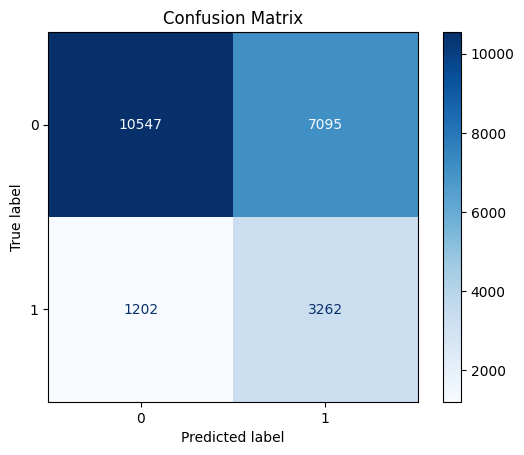

In [76]:
predictions_test = predictions_test.flatten()
acc = accuracy_score(y_cv, predictions_test)
prec, rec, thresholds = precision_recall_curve(y_cv, probabilities)
auc0 = sk_auc(rec,prec)
f1 = f1_score(y_cv, predictions_test, average="weighted")    #using weighted f1 for imbalanced data
cm = confusion_matrix(y_cv, predictions_test)

print("NUMPY PERFORMANCE METRICS--------------")
print("Accuracy:", acc)
print("Precision Recall AUC:", auc0)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

PYTORCH PERFORMANCE METRICS----------
Accuracy: 0.6294218764136433
Precision Recall AUC: 0.34365867004184714
F1 Score: 0.6659351291223935
Confusion Matrix:
 [[10557  7085]
 [ 1107  3357]]


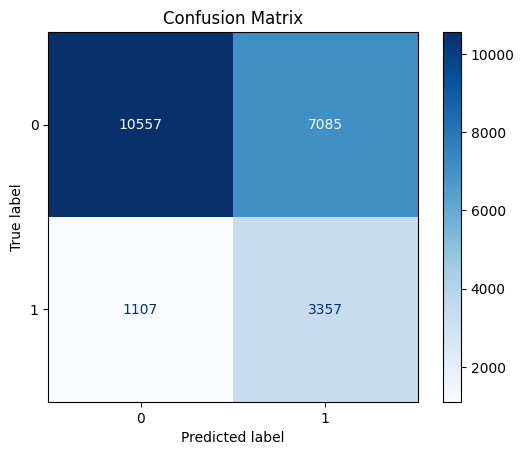

In [22]:
acc = accuracy_score(y_cv_t, y_cv_pred_opt)
prec, rec, thresholds = precision_recall_curve(y_cv_t, probs_cv)
auc1 = sk_auc(rec,prec)
f1 = f1_score(y_cv_t, y_cv_pred_opt, average="weighted")
cm = confusion_matrix(y_cv_t, y_cv_pred_opt)

print("PYTORCH PERFORMANCE METRICS----------")
print("Accuracy:", acc)
print("Precision Recall AUC:", auc1)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)

display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()